In [1]:
import os, json
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from utils.data import DataTree

import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/032125"
dtree = DataTree("../data")

## Example TAD calling

In [4]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})
noisy_loader = sf.pp.FOF_CT_Loader({
    "rep1": os.path.join(out_dire, "takei_nature_25kb_rep1.csv"),
    "rep2": os.path.join(out_dire, "takei_nature_25kb_rep2.csv")
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})

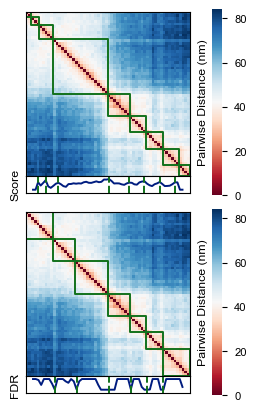

In [5]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)

fig, axes = plt.subplots(2, 1, figsize=(2.3, 4))
caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
sf.pl.domain_boundary(adata, caller, ax=axes[0])
caller = sf.tl.TADCaller(tree=False, method="pval")
sf.pl.domain_boundary(adata, caller, ax=axes[1])
for ax in axes:
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pairwise Distance (nm)", labelpad=-35)    
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD.pdf"), bbox_inches="tight")

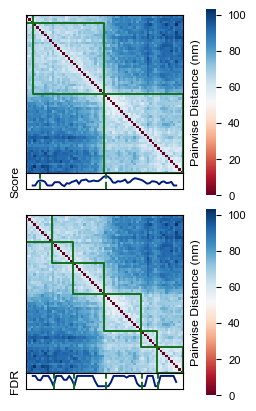

In [6]:
chr_id = "chr3"
adata = noisy_loader.create_adata(chr_id)

fig, axes = plt.subplots(2, 1, figsize=(2.3, 4))
caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
sf.pl.domain_boundary(adata, caller, ax=axes[0])
caller = sf.tl.TADCaller(tree=False, method="pval")
sf.pl.domain_boundary(adata, caller, ax=axes[1])
for ax in axes:
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD_noisy.pdf"), bbox_inches="tight")

## Correlation with ChIP-seq

In [7]:
res_sf1_path = os.path.join(out_dire, "tad_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    tad = sf.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    sf.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "tad_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    tad = sf.tl.TADCaller(tree=False, method="pval")
    sf.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

In [8]:
res_sf1_noisy_path = os.path.join(out_dire, "tad_result_sf1_noisy.csv")
if not os.path.exists(res_sf1_noisy_path):
    tad = sf.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    sf.wr.caller_wrapper(noisy_loader, tad=tad, tad_path=res_sf1_noisy_path)
res_sf1_noisy = pd.read_csv(res_sf1_noisy_path, sep="\t")
res_sf2_noisy_path = os.path.join(out_dire, "tad_result_sf2_noisy.csv")
if not os.path.exists(res_sf2_noisy_path):
    tad = sf.tl.TADCaller(tree=False, method="pval")
    sf.wr.caller_wrapper(noisy_loader, tad=tad, tad_path=res_sf2_noisy_path)
res_sf2_noisy = pd.read_csv(res_sf2_noisy_path, sep="\t")

In [9]:
from utils.utils import domain_chipseq_df
markers = ["CTCF", "POLR2A", "H3K4me3", "H3K36me3", "H3K9me3"]
raw_enrich_path = os.path.join(out_dire, "tad_raw_enrich_chipseq.csv")
if not os.path.exists(raw_enrich_path):
    raw_enrich_df = domain_chipseq_df(dtree, loader, res_sf1, res_sf2, markers)
    raw_enrich_df.to_csv(raw_enrich_path, index=False, sep="\t")
raw_enrich_df = pd.read_csv(raw_enrich_path, sep="\t")
noi_enrich_path = os.path.join(out_dire, "tad_noi_enrich_chipseq.csv")
if not os.path.exists(noi_enrich_path):
    noi_enrich_df = domain_chipseq_df(dtree, noisy_loader, res_sf1_noisy, res_sf2_noisy, markers)
    noi_enrich_df.to_csv(noi_enrich_path, index=False, sep="\t")
noi_enrich_df = pd.read_csv(noi_enrich_path, sep="\t")

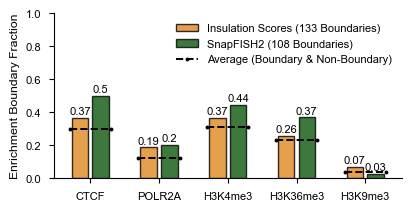

In [10]:
from utils.lines import domain_chipseq_barplot
fig, ax = plt.subplots(figsize=(4, 2))
domain_chipseq_barplot(raw_enrich_df, ax=ax)
fig.savefig(os.path.join(out_dire, "tad_raw_enrich_chipseq.pdf"), bbox_inches="tight")

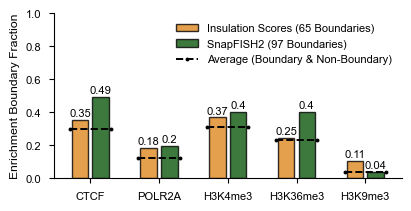

In [11]:
fig, ax = plt.subplots(figsize=(4, 2))
domain_chipseq_barplot(noi_enrich_df, ax=ax)
fig.savefig(os.path.join(out_dire, "tad_noi_enrich_chipseq.pdf"), bbox_inches="tight")

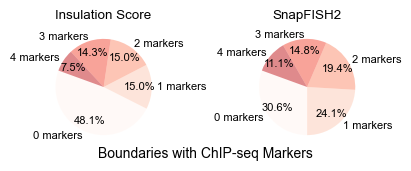

In [12]:
from utils.utils import domain_add_chipseq_col

colors = [plt.get_cmap("Reds")(i*50) for i in range(5)]
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

res = res_sf1.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[0].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75,
    wedgeprops={"alpha": .5}, colors=colors,
)
axes[0].set_title("Insulation Score")

res = res_sf2.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[1].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75, 
    wedgeprops={"alpha": .5}, colors=colors
)
axes[1].set_title("SnapFISH2")

fig.suptitle("Boundaries with ChIP-seq Markers", y=0.2, fontsize=10)
fig.savefig(os.path.join(out_dire, "tad_marker_pie.pdf"), bbox_inches="tight")